In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '001_eda'
competition: atmacup8
seed: 1019
training:
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'train.csv')
df_test = pd.read_csv(datadir / 'test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 16), (8360, 11))

In [6]:
df_train.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [7]:
df_test.head().T

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4
Name,Hitman 2: Silent Assassin,Legacy of Kain: Soul Reaver,Metal Gear Solid 2: Substance,Silent Hill: Homecoming,Silent Hill: Homecoming
Platform,XB,PS,XB,X360,PS3
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Eidos Interactive,Eidos Interactive,Konami Digital Entertainment,Konami Digital Entertainment,Konami Digital Entertainment
Critic_Score,84,91,87,70,71
Critic_Count,23,17,28,54,41
User_Score,8,9,8.5,6.9,6.9
User_Count,19,132,39,180,143
Developer,Io Interactive,Crystal Dynamics,KCEJ,Double Helix Games,Double Helix Games


In [8]:
df_submission.head()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Global_Sales
0,63.371815
1,63.371815
2,63.371815
3,63.371815
4,63.371815


In [9]:
df_train.reset_index()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,0,4,0,0,4,78.0,57.0,8,569.0,Paradox Development Studio,NaN
8355,8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
8356,8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
8357,8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,0,0,4,0,4,NaN,NaN,NaN,NaN,NaN,NaN


# train

In [10]:
len(list(df_train.columns)), list(df_train.columns)

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(16,
 ['Name',
  'Platform',
  'Year_of_Release',
  'Genre',
  'Publisher',
  'NA_Sales',
  'EU_Sales',
  'JP_Sales',
  'Other_Sales',
  'Global_Sales',
  'Critic_Score',
  'Critic_Count',
  'User_Score',
  'User_Count',
  'Developer',
  'Rating'])

# df_train と df_test の venn

In [11]:
discrete_columns = [
 'Name',
 'Platform',
 'Year_of_Release',
 'Genre',
 'Publisher',
 'Developer',
 'Rating'
]
len(discrete_columns)

7

In [12]:
def show_venn(train, test, column, i = None):
    train_ = train.copy()
    test_ = test.copy()
    if i is not None:
        plt.subplot(6, 4, i)
    test_[column] = test_[column].fillna(0)
    train_[column] = train_[column].fillna(0)
    venn2([set(train_[column]), set(test_[column])])
    title = column + f'; train - test: {len(set(train_[column]) - set(test_[column]))}\n'
    title += f'train null: {np.sum(train_[column].isna())}, {np.mean(train_[column].isna())*100:.1f}%\n'
    title += f'test null: {np.sum(test_[column].isna())}, {np.mean(test_[column].isna())*100:.1f}%\n'
    plt.title(title)

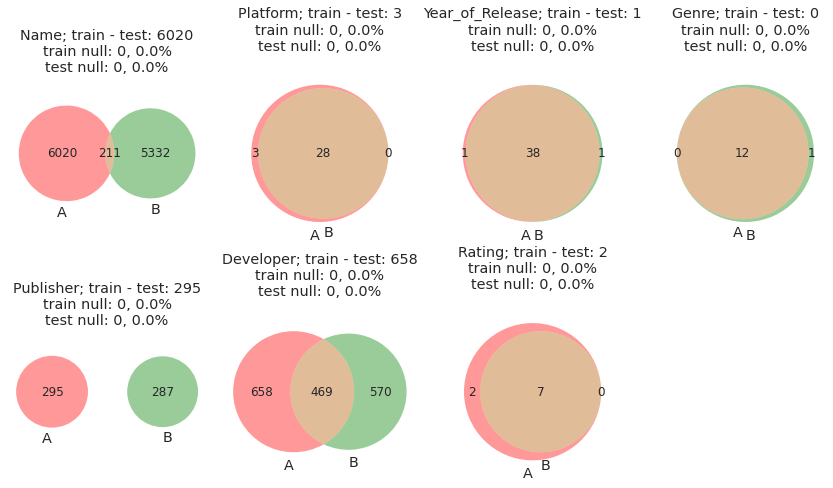

In [13]:
plt.figure(figsize=(12, 20))
plt.rcParams["font.size"] = 12
for i, column in enumerate(discrete_columns):
    show_venn(df_train, df_test, column, i + 1)
plt.tight_layout()

# train/test 

In [14]:
train = df_train.copy()
test = df_test.copy()

train.loc[:, 'is_test'] = False
test.loc[:, 'is_test'] = True
whole = pd.concat([train, test])
whole.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,is_test
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180.0,97.0,0.0,28.0,306.0,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,False
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151.0,61.0,0.0,21.0,234.0,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,False
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56.0,44.0,0.0,27.0,128.0,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,False
3,Combat,2600,NaN,Action,Atari,117.0,7.0,0.0,1.0,125.0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69.0,42.0,0.0,12.0,124.0,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,False


## categry を見る

In [15]:
def countplot(df: pd.DataFrame, column: str) -> None:
    print(f'{column}: {len(df.loc[:, column].unique())}, {df.loc[:, column].unique()}')
    plt.figure(figsize=(20, 8))
    sns.countplot(data=df, x=column, hue='is_test')
    plt.title(column)
    plt.tight_layout()

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Platform: 31, ['Wii' 'PSP' '2600' 'X360' 'PS3' 'GBA' 'DS' '3DS' 'PC' 'GC' 'GB' 'PS2'
 'N64' 'PSV' 'XB' 'NES' 'GEN' 'SNES' 'GG' 'NG' 'SCD' 'PS' 'SAT' '3DO'
 'TG16' 'PCFX' 'DC' 'WS' 'WiiU' 'PS4' 'XOne']


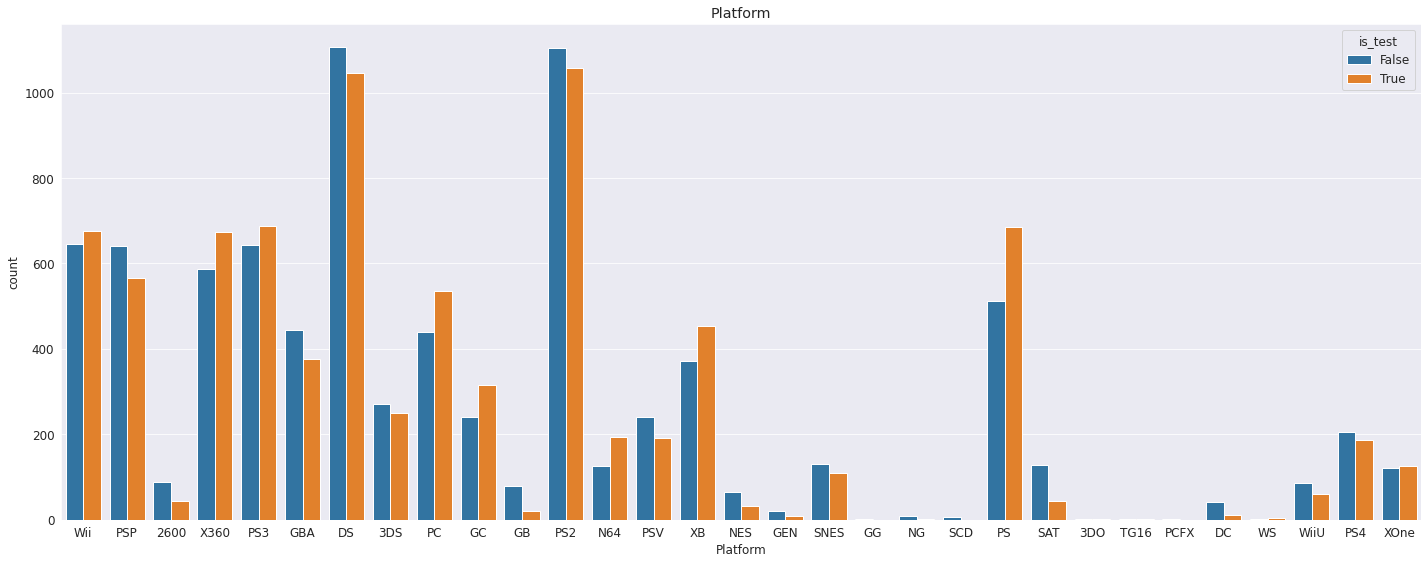

In [16]:
countplot(whole, 'Platform')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Year_of_Release: 40, [  nan 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990.
 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002.
 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014.
 2015. 2016. 2017. 2020.]


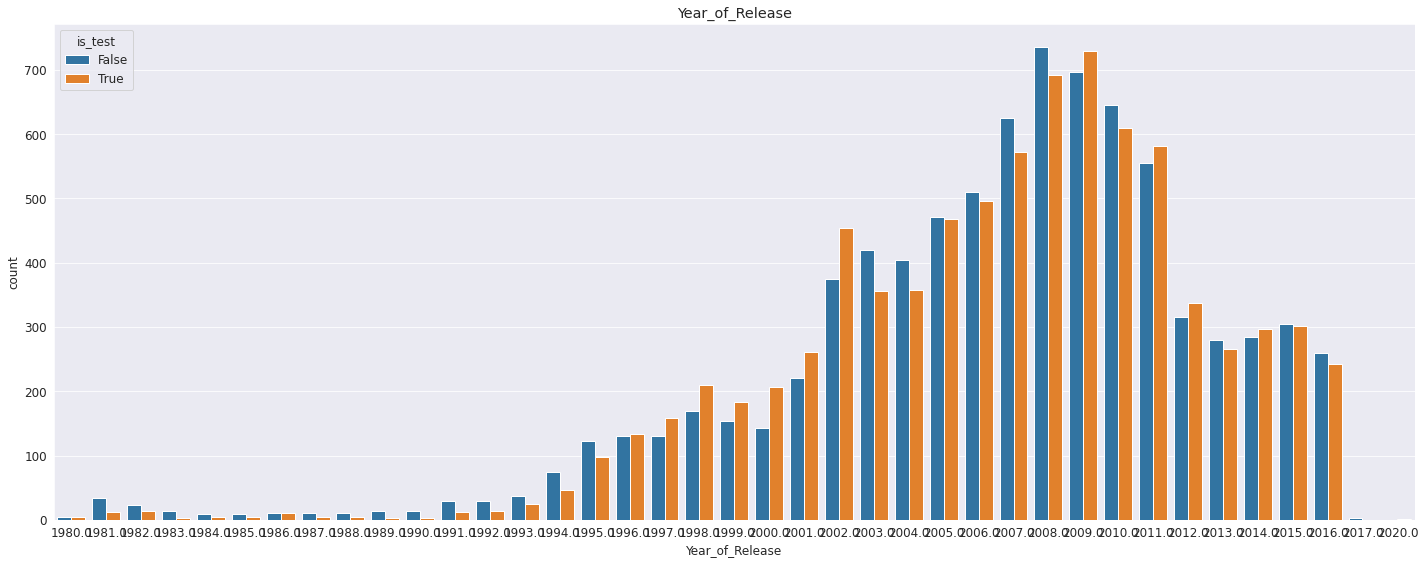

In [17]:
countplot(whole, 'Year_of_Release')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Genre: 13, ['Action' 'Adventure' 'Fighting' 'Misc' 'Platform' 'Puzzle' 'Racing'
 'Role-Playing' 'Shooter' 'Simulation' 'Sports' 'Strategy' nan]


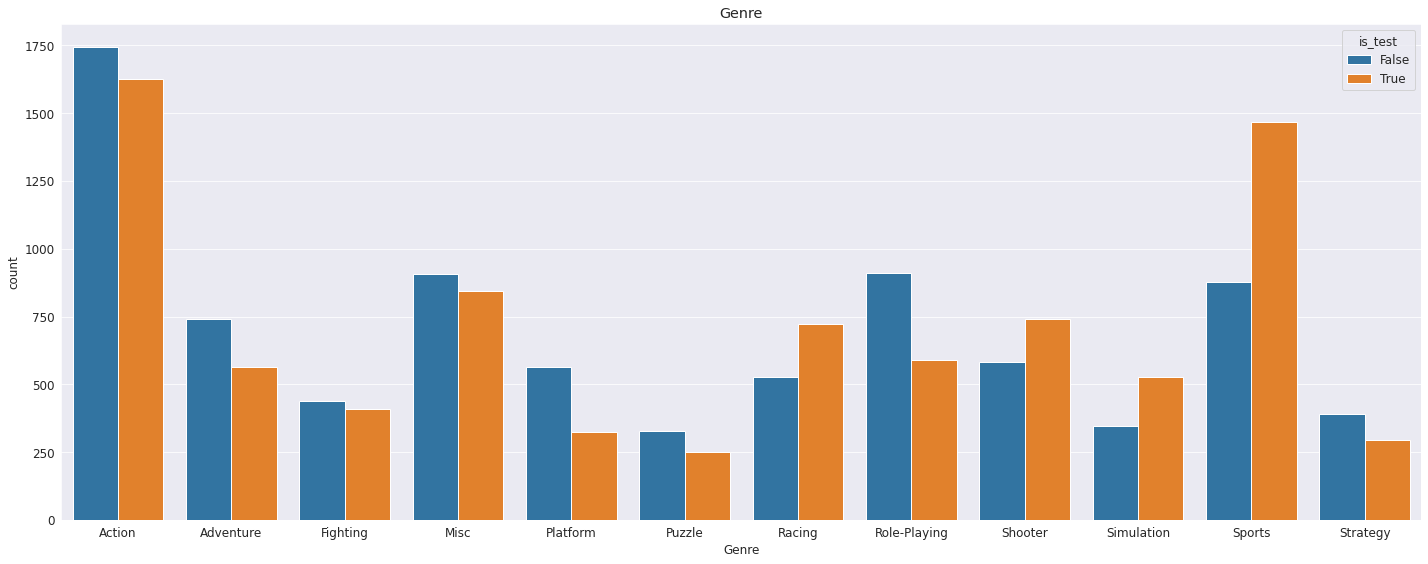

In [18]:
countplot(whole, 'Genre')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Publisher: 582, ['Warner Bros. Interactive Entertainment' 'LucasArts' 'Atari' 'Sega'
 'Disney Interactive Studios' 'Vivendi Games' 'Square Enix' 'Nintendo'
 'Ignition Entertainment' 'THQ' 'Focus Home Interactive' 'Capcom'
 'MTV Games' 'Funsta' 'Majesco Entertainment' 'System 3 Arcade Software'
 'Nippon Ichi Software' 'Idea Factory' 'Bethesda Softworks'
 'Take-Two Interactive' 'D3Publisher' 'Kalypso Media'
 'Sony Computer Entertainment' 'Oxygen Interactive' 'Ghostlight'
 'Slitherine Software' 'Parker Bros.' 'Mystique' 'Men-A-Vision'
 'Tigervision' 'Mattel Interactive' 'Coleco' 'Imagic' 'Taito'
 'ITT Family Games' 'Bomb' 'Quelle' 'Mycom' 'Enix Corporation'
 'SquareSoft' 'Maxis' 'Palcom' 'HAL Laboratory' 'Tecmo Koei' 'Epoch'
 'Square' 'Kemco' 'Imagineer' 'Banpresto' 'ChunSoft' 'Takara'
 'Video System' 'id Software' 'SNK' 'Sammy Corporation' 'Imax' 'Laguna'
 'TOHO' 'Red Orb' 'Hasbro Interactive' 'Micro Cabin' 'Atlus' 'Game Arts'
 'From Software' 'Core Design Ltd.' 'Media Rings' 'Asmik Corp

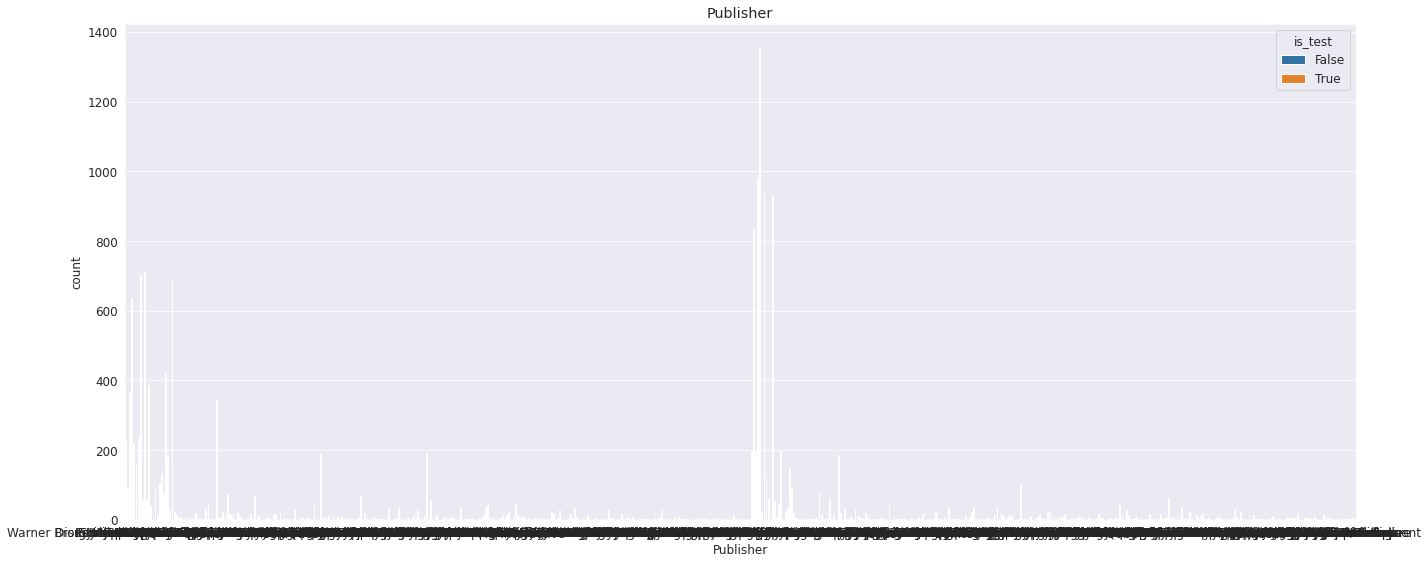

In [19]:
countplot(whole, 'Publisher')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Developer: 1697, ["Traveller's Tales" nan 'Ryu ga Gotoku Studios' ...
 'EA Sports, EA Vancouver' 'EA Canada, EA Vancouver'
 'The Digital Lounge, Dino Dini']


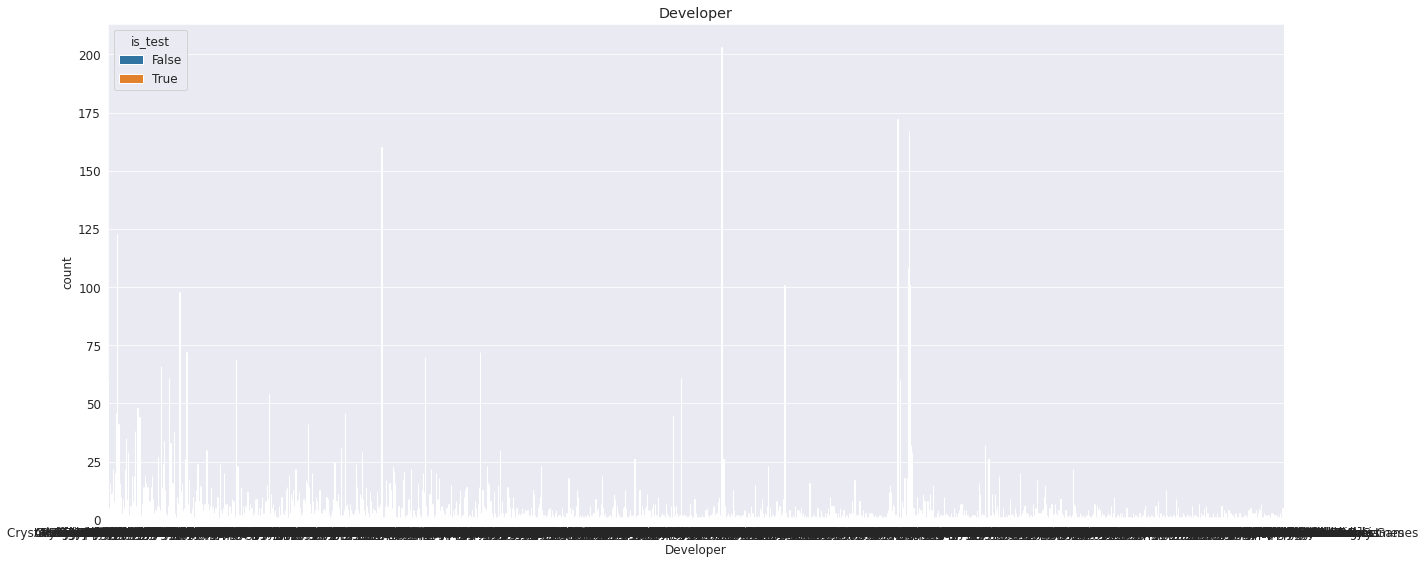

In [20]:
countplot(whole, 'Developer')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Rating: 9, ['E10+' nan 'M' 'E' 'T' 'K-A' 'AO' 'EC' 'RP']


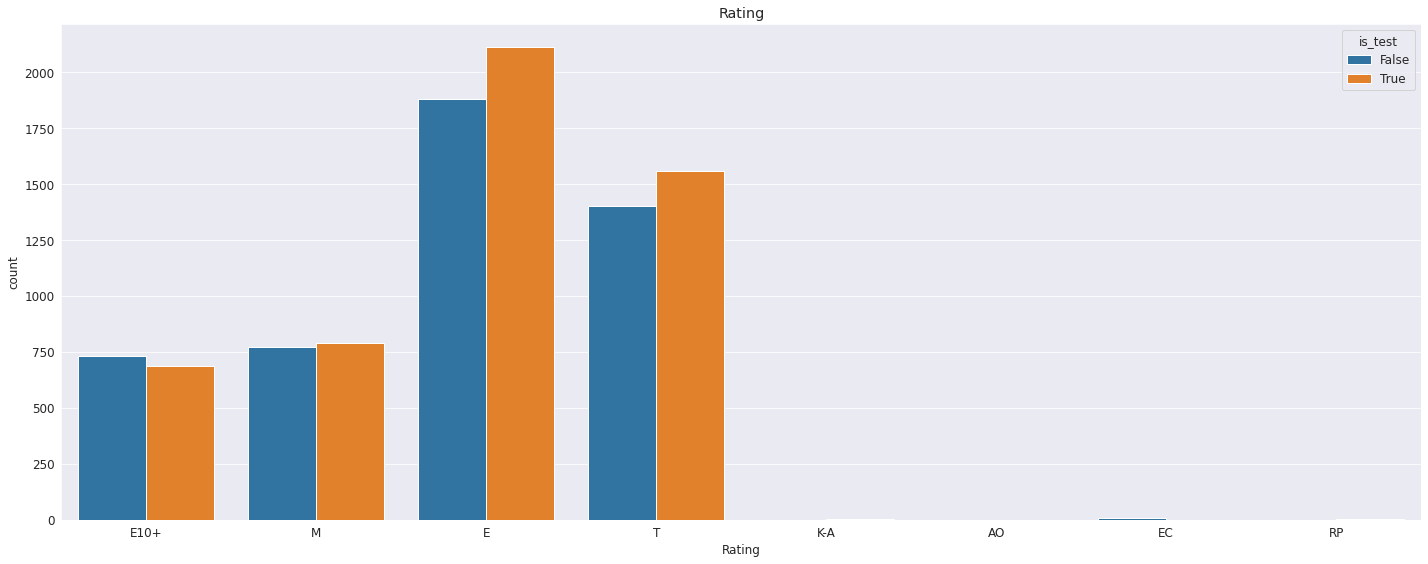

In [21]:
countplot(whole, 'Rating')

In [ ]:
# 一定期間のデータを Publisher で分割したっぽい

In [ ]:
# publisher

In [ ]:
publisher_count = whole.loc[:, 'Publisher'].value_counts()
publisher_count.shape

In [ ]:
for n in range(10):
    print(f'{n}:', publisher_count[publisher_count == n].shape[0], 'cumsum:', publisher_count[publisher_count <= n].shape[0])

# Name をみる

In [ ]:
whole.loc[:, ['Name']].value_counts()

In [ ]:
whole[whole['Name'] == 'FIFA 14']

Name がかぶってるやつは複数 Platform で出てるやつ

# Score, Count をみる

In [ ]:
train = df_train.copy()
test = df_test.copy()

train.loc[:, 'is_test'] = False
test.loc[:, 'is_test'] = True
whole = pd.concat([train, test])

In [ ]:
train.loc[:, 'User_Count']

In [ ]:
train.loc[:, 'User_Score'] / 10.0

In [ ]:
# nan の割合
print('User_Score train:', train[train['User_Score'].isna()].shape[0], train[train['User_Score'].isna()].shape[0] / train.shape[0])
print('User_Score test:', test[test['User_Score'].isna()].shape[0], test[test['User_Score'].isna()].shape[0] / test.shape[0])
print('Critic_Score train:', train[train['Critic_Score'].isna()].shape[0], train[train['Critic_Score'].isna()].shape[0] / train.shape[0])
print('Critic_Score test:', test[test['Critic_Score'].isna()].shape[0], test[test['Critic_Score'].isna()].shape[0] / test.shape[0])

In [ ]:
# 数字でも NaN でもないやつある? -> ある。tbd が 1132 個
train[~train['User_Score'].isna() & train['User_Score'].str.isalpha()]['User_Score'].value_counts()

In [ ]:
# train[~train['Critic_Score'].isna() & train['Critic_Score'].str.isalpha()]['Critic_Score'].value_counts()
# Critic_Score にはない

In [ ]:
# tbd をみる。User_Count は nan になる
train[~train['User_Score'].isna() & train['User_Score'].str.isalpha()].head()

In [ ]:
# tbd と nan 何が違う?
train[train['User_Score'].isna()]

In [ ]:
train.loc[train['User_Score'] == 'tbd', 'User_Score'] = np.nan

In [ ]:
train['User_Score'].astype(np.float32)

In [ ]:
train['User_Score'].astype(np.float32) / 10.0

In [ ]:
train['User_Score'] = train.loc[:, 'User_Score'].fillna(-1)
train['Critic_Score'] = train.loc[:, 'Critic_Score'].fillna(-1)

In [ ]:
print(train['User_Score'].astype(np.float32).describe())
sns.distplot(train['User_Score'])

In [ ]:
print(train['Critic_Score'].describe())
sns.distplot(train['Critic_Score'])

In [ ]:
print(train['User_Count'].describe())
sns.distplot(train['User_Count'])

In [ ]:
print(train['Critic_Count'].describe())
sns.distplot(train['Critic_Count'])

In [ ]:
# Sales

In [ ]:
df_train.loc[:, 'Global_Sales'].describe()